# Project: Music Generation with RNN

Info: The notebook is just for visualisation and explanation of the python code and won't run like a normal notebook.
To run the code clone the Github repo and run the main.py file: e.g `python main.py --train small_model`.

## Agenda:
1. Project Structure and Overview
2. Data Access, Data Understanding, Preprocessing, Feature Selection or Feature Extraction
3. Machine Learning
4. Evaluation, Optimization and Visualisation
5. Discussion and Conclusion

## 1. Project Structure and Overview

The Project consists of three files which all relate to a different stage of the data mining process:
* main.py - the file to execute
* midihelper.py - Data Access, Data Understanding, Preprocessing, Feature Selection or Feature Extraction
* neuralnetwork.py - Machine Learning, Evaluation and Optimization (Visualisation wil be done in the notebook)

### main.py

This file should be executed to start the training of the neural network and generate music afterwards. It awaits one mandatory command line argument and two optional parameters:

1. `--train` or `--no-train` - a flag to indicate if the network should be trained or used for music generation 
2. `--midifile` or `-m` - the name of the midi file which should be created
3. `modelName` - the name of the neural network which should be created, must match the method names of the models in the neuralnetwork.py file

In [ ]:
from midihelper import MidiHelper, generate_midi_from_prediction
from neuralnetwork import CustomModel
import argparse

# get all methods which creates a neural network and should be used as the modelName argument
allowed_methods = [func for func in dir(CustomModel) if callable(getattr(CustomModel, func)) and "model" in str(func)]

# init the argument parser and add the arguments
parser = argparse.ArgumentParser(description='Generate classical music in the style of Frederic Chopin.')
parser.add_argument('--train', dest='train', action='store_true')
parser.add_argument('--no-train', dest='train', action='store_false')
parser.set_defaults(train=True)
parser.add_argument('-m', '--midifile', nargs='?', dest="midifile", type=str, help='output file, in midi format')
parser.add_argument("modelName", help="the name of the model which should be created," +
                                      " must match one of this method names: " + str(allowed_methods),
                    type=str)
args = parser.parse_args()

# create the midihelper and generate the network input and output
midiHelper = MidiHelper("chopin-midi", "chopinNotesWithOffset")
network_input, network_output = midiHelper.generate_sequences(100)

# init the network class, train network and predict notes
net = CustomModel(network_input, network_output, midiHelper.get_notes(), args.modelName, args.train)
net.train_network(epochs=200, batch_size=64)
generated_music = net.generate_music(1000)

# generate the midi file from the predicted notes
midi_name = args.midifile if args.midifile is not None else 'default.mid'
midi_name = args.modelName if args.midifile is None and args.train is True else midi_name
generate_midi_from_prediction(generated_music, midi_name)

## 2. Data Access, Data Understanding, Preprocessing, Feature Selection or Feature Extraction

All of these different stages of the process are implemented in the midihelper.py file.

### Data Access 
The midi files were retrieved from this site: http://www.piano-midi.de/chopin_d.htm 

### Data Understanding
There are three different format of midi files:
* Type 0 - all the tracks are merged into a single track
* Type 1 - separate information for each track
* Type 2 - contain one or more independant tracks 

For more information: https://www.csie.ntu.edu.tw/~r92092/ref/midi/

### Preprocessing

For handling of the midi files the music21 library is used: http://web.mit.edu/music21/

The class needs two parameters. The path to the folder which contains the midi files and the name of the file which the processed midi files should be saved, so that the midi files only needs to be processed one time if they don't change.

In [ ]:
import glob
import pickle
import os
import numpy as np
from keras.utils import np_utils
from music21 import converter, instrument, note, chord, stream


class MidiHelper:

    def __init__(self, path, name):
        self.path = path # path to the folder of the midi files
        self.name = name # the file name to save the processed midi files
        self.notes = [] # all the notes with the offset used in all midi files
        self.notes = self.get_notes() # get the notes from the midi files or from the saved python object

    def create_notes(self):
        self.notes = []
        
        # loop over all midi files in the folder
        for file in glob.glob(self.path + "/*.mid"):
            # parse midi file
            midi = converter.parse(file)
            
            # get the different parts of the midi file => type 1 or type 0
            parts = instrument.partitionByInstrument(midi)
            
            # recurse: http://web.mit.edu/music21/doc/moduleReference/moduleStream.html?highlight=recurse#music21.stream.Stream.recurse
            notes_to_parse = parts.parts[0].recurse() if parts else midi.flat.notes
            
            # calculate the different offsets of chords or notes
            last_offset_notes = 0
            last_offset_chords = 0
            
            # loop over all elements of the single midi file 
            for element in notes_to_parse:
                # create the notes or chords and calculate the offset
                if isinstance(element, note.Note):
                    offset = element.offset - last_offset_notes
                    last_offset_notes = element.offset
                    self.notes.append(str(element.pitch) + "," + str(offset))
                elif isinstance(element, chord.Chord):
                    offset = element.offset - last_offset_chords
                    last_offset_chords = element.offset
                    # append each note with a _ and add the offset at the end separated with a comma
                    self.notes.append('_'.join(str(n) for n in element.normalOrder) + "," + str(offset))

        # save notes so that loading is faster
        with open(self.name, 'wb') as f:
            pickle.dump(self.notes, f)

        return self.notes

    # get the parsed notes of all midi files
    def get_notes(self):
        # check if notes already created
        if self.notes and len(self.notes) != 0:
            return self.notes

        # if notes file with the name exists => use it
        if os.path.isfile(self.name):
            print('Loaded notes from file')
            with open(self.name, 'rb') as f:
                self.notes = pickle.load(f)
                return self.notes
            
        # else create new notes with midi files
        else:
            print('Create new notes out of midi files')
            return self.create_notes()

    # map notes to integers
    def get_note_to_int_mapping(self):
        # get all pitch names
        pitch_names = sorted(set(self.notes))
        # create a dictionary to map pitches to integers
        note_to_int = dict((note, number) for number, note in enumerate(pitch_names))
        return note_to_int

    def get_size_of_output_classes(self):
        return len(set(self.notes))

### Feature Selection or Feature Extraction

This method generates the network input and output sequences to train the neural network

In [ ]:
    # generate the sequences which are the input for the neural network
    def generate_sequences(self, sequence_length):
        note_to_int = self.get_note_to_int_mapping()

        network_input = []
        network_output = []

        # create input sequences and the corresponding outputs like in Ass05
        for i in range(0, len(self.notes) - sequence_length, 1):
            sequence_in = self.notes[i:i + sequence_length]
            sequence_out = self.notes[i + sequence_length]
            network_input.append([note_to_int[char] for char in sequence_in])
            network_output.append(note_to_int[sequence_out])

        n_patterns = len(network_input)

        # reshape the input into a format compatible with neural network layers
        network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

        # normalize input
        network_input = network_input / float(self.get_size_of_output_classes())
        
        # Convert class vector (integers from 0 to nb_classes) to binary class matrix, for use with categorical_crossentropy.
        network_output = np_utils.to_categorical(network_output)

        return network_input, network_output

## 3. Machine Learning

### The CustomModel class

This class contains all methods to train and create different neural network models. It is also able to generate new music sequences. This sequences are only the predicted notes in integers and must be transformed to notes which can be converted into a midi file.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import numpy as np
import pickle


class CustomModel:

    def __init__(self, network_input, network_output, notes, model_name, train):
        self.network_input = network_input
        self.network_output = network_output
        self.notes = notes
        self.n_vocab = len(set(notes))
        self.model_name = model_name
        self.train = train

        # if in train mode create the neural network with the model_name which must map to a method
        if self.train:
            self.model_path = "./weights/" + self.model_name + ".hdf5"
            # https://stackoverflow.com/questions/3061/calling-a-function-of-a-module-by-using-its-name-a-string
            if os.path.isfile(self.model_path):
                self.model = load_model(self.model_path)
            else:
                self.model = getattr(self, self.model_name)()
        else:
            self.model_path = model_name
            self.model = load_model(self.model_path)

    def train_network(self, epochs, batch_size):
        if not self.train:
            return

        # checkpoint the model and save every 50 epochs the model
        file_path = "./weights/" + self.model_name + "-{epoch:02d}-{loss:.4f}.hdf5"
        checkpoint = ModelCheckpoint(
            file_path,
            monitor='loss',
            verbose=0,
            save_best_only=False,
            mode='min',
            period=50
        )
        callbacks_list = [checkpoint]

        # train the model
        history = self.model.fit(self.network_input, self.network_output, epochs=epochs,
                                 batch_size=batch_size, callbacks=callbacks_list)

        # save history of model
        with open("./" + self.model_name + "_history", 'wb') as f:
            pickle.dump(history.history, f)

        self.model.save(self.model_path)

        # model is trained so set flag to false
        self.train = False

    def get_int_to_note_mapping(self):
        # get all pitch names
        pitch_names = sorted(set(self.notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitch_names))
        return int_to_note

### The different trained and evaluated models 
These models were trained and evaluated. As an evaluation with the known metrics for music generation is inappropriate, only the loss curve is plotted.

In [2]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
sb.set_style('whitegrid')
sb.set_context('notebook')

# load the saved history and plot the loss
def plot_loss_from_saved_history(path):
    history = None
    with open(path, 'rb') as f:
        history = pickle.load(f)

    loss = history['loss']
    min_train_loss=np.min(loss)

    epochs = range(1, len(loss) + 1)

    plt.figure()

    plt.plot(epochs[1:], loss[1:], label='Training loss')
    plt.title('Training loss')
    plt.legend()

    plt.show()
    
    print("Minimum Loss on training data: ", min_train_loss)
        

In [14]:
    def big_model(self):
        model = Sequential()
        model.add(LSTM(
            512,
            input_shape=(self.network_input.shape[1], self.network_input.shape[2]),
            return_sequences=True
        ))
        model.add(Dropout(0.3))
        model.add(LSTM(512, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(512))
        model.add(Dense(2048))
        model.add(Dropout(0.3))
        model.add(Dense(self.n_vocab))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model

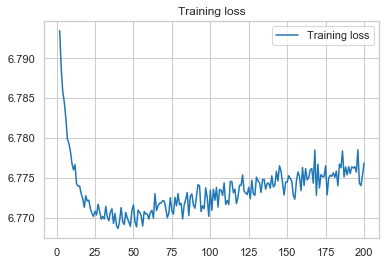

Minimum Loss on training data:  6.7686880373


In [15]:
plot_loss_from_saved_history("big_model_history")

In [16]:
    def small_model(self):
        model = Sequential()
        model.add(LSTM(
            256,
            input_shape=(self.network_input.shape[1], self.network_input.shape[2]),
            return_sequences=True
        ))
        model.add(Dropout(0.3))
        model.add(LSTM(256))
        model.add(Dense(2048))
        model.add(Dropout(0.3))
        model.add(Dense(self.n_vocab))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model

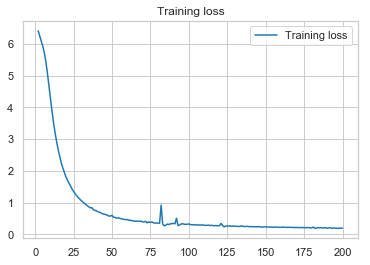

Minimum Loss on training data:  0.190600126362


In [17]:
plot_loss_from_saved_history("small_model_history")

In [3]:
    def small_model2(self):
        model = Sequential()
        model.add(LSTM(
            128,
            input_shape=(self.network_input.shape[1], self.network_input.shape[2]),
            return_sequences=True
        ))
        model.add(Dropout(0.3))
        model.add(LSTM(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(128))
        model.add(Dense(2048))
        model.add(Dropout(0.3))
        model.add(Dense(self.n_vocab))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model

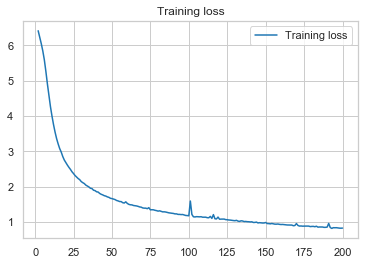

Minimum Loss on training data:  0.818565505648


In [4]:
plot_loss_from_saved_history("small_model2_history")

In [19]:
    def model(self):
        model = Sequential()
        model.add(LSTM(
            512,
            input_shape=(self.network_input.shape[1], self.network_input.shape[2]),
            return_sequences=True
        ))
        model.add(Dropout(0.3))
        model.add(GRU(512, activation='relu', dropout=0.3, recurrent_dropout=0.5, return_sequences=True))
        model.add(LSTM(512))
        model.add(Dense(2048))
        model.add(Dropout(0.3))
        model.add(Dense(2048))
        model.add(Dropout(0.3))
        model.add(Dense(self.n_vocab))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model

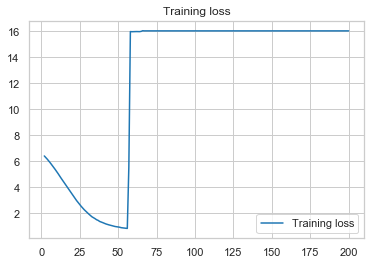

Minimum Loss on training data:  0.843177202649


In [20]:
plot_loss_from_saved_history("model_history")

In [ ]:
    def model_gru(self):
        model = Sequential()
        model.add(GRU(
            128,
            input_shape=(self.network_input.shape[1], self.network_input.shape[2]),
            return_sequences=True
        ))
        model.add(Dropout(0.3))
        model.add(GRU(128, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(GRU(128))
        model.add(Dense(2048))
        model.add(Dropout(0.3))
        model.add(Dense(self.n_vocab))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model

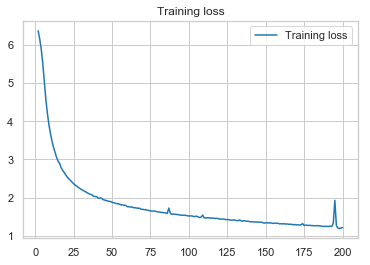

Minimum Loss on training data:  1.1917844667


In [5]:
plot_loss_from_saved_history("model_gru_history")

### Music Generation (4. Evaluation and Visualisation)

This chapter describes how music can be generated with a trained neural network. As the network is not able to generate music from the beginning with an own start sequence, a random integer will choose an input pattern from the network inputs. With this pattern the network can predict new music but it will only predict the indexes of the notes, so the indexes must be converted into the notes.

In [ ]:
    def generate_music(self, sequence_length):
        # in train mode so no music should be generated
        if self.train:
            return

        print("Start generating music..")
        
        # there is no start sequence for predicting the notes so a random sequence from the network input will be used
        start = np.random.randint(0, len(self.network_input) - 1)        
        int_to_note = self.get_int_to_note_mapping()
        pattern = self.network_input[start]
        prediction_output = []

        # generate sequence_length notes
        for note_index in range(sequence_length):
            prediction_input = np.reshape(pattern, (1, len(pattern), 1))
            
            # normalize input
            prediction_input = prediction_input / float(self.n_vocab)
            prediction = self.model.predict(prediction_input, verbose=1)
            
            # get predicted index and convert it into a note
            index = int(np.argmax(prediction))
            result = int_to_note[index]
            prediction_output.append(result)
            
            # append predicted note to pattern and remove the first note for the new input sequence
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]

        return prediction_output

The method below this text will generate a midi file with the generated sequence of the network. The sequence contains the notes with the corresponding offset. The notes and chords will be created with the midi21-library and in the end a new midifile is created.

In [ ]:
# in midihelper.py file
def generate_midi_from_prediction(prediction_output, file_name):
    offset = 0
    output_notes = []
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # split pattern and offset, if only notes were predicted without a offset then set a standard offset of 0.5
        pattern_and_offset = pattern.split(',')
        print(pattern_and_offset)
        if len(pattern_and_offset) != 2:
            pattern_and_offset = [pattern, 0.5]

        pattern = pattern_and_offset[0]
        # pattern is a chord
        if ('_' in pattern) or pattern.isdigit():
            # split the chord representation and create it with all information necessary for the midi files
            notes_in_chord = pattern.split('_')
            notes = []

            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)

            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)

        # pattern is a note
        else:
            # create new note with all information necessary for the midi files
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # check if offset is a number and not a fraction
        if "/" in pattern_and_offset[1]:
            numbers = pattern_and_offset[1].split('/')
            if len(numbers) == 2:
                pattern_and_offset[1] = float(numbers[0]) / float(numbers[1])
            else:
                pattern_and_offset[1] = 0.5  # if not two numbers are given set a standard offset

        # increase offset each iteration so that notes do not stack
        offset += float(pattern_and_offset[1])

    # check if file_name has the correct extension
    if not file_name.endswith('.mid'):
        file_name = file_name + '.mid'

    # create the midi file
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=file_name)

## 5. Discussion and Conclussion

Generating music with neural networks is different from other tasks, because there are no good metrics for monitoring the training. There is no correct or false predicted note as everyone likes other styles of music. 

A few things I noticed:

* minimizing the error not always improves the generated music
* there can be a huge improvement with more epochs training although the loss is almost the same
* use another loss function as not only one note is correct but more notes could be correct (maybe check for the intervals)
* sometimes whole parts of the generated music are copied from the training data or almost sounds similar